In [121]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/home/tomoaki/work")
import my_utils

In [122]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [123]:
print ("Started!!")

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data, date, input_list = my_utils.get_fixed_data(input_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
('fail_name_list: ', [])
time for getting data: 184.899176121


In [128]:
print (input_data.shape)

(253, 98)


In [125]:
date_label = my_utils.get_datetime_list(date)

# DDPG for trading


Given data, you are going to learn how to manage your portfolio.

In [129]:
# memory for replay
from collections import deque, namedtuple

Experiecne = namedtuple('Experience', 'state0, action, reward, state1')

class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        # self.data = [None for _ in range(maxlen)]
        self.data = []
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx< 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]
    
    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item
            self.data[1:] = self.data[:-1]
        else:
            # This should never happen
            raise RuntimeError()
        self.data.append(v)
        
class SequentialMemory(object):
    def __init__(self, limit=1000):
        self.limit = limit
        
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.observations = RingBuffer(limit)
        
    def sample(self, batch_size, window_length):
        # draw random indexes such that is bigger than window_length to enough length data
        batch_idx = np.random.random_integers(window_length, self.nb_entries - 1, size=batch_size)
        assert len(batch_idx) == batch_size
        
        # create experiences
        state0 = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        action = np.array([self.actions[idx - 1] for idx in batch_idx])
        reward = np.array([self.rewards[idx - 1] for idx in batch_idx])
        state1 = np.array([[self.observations[i] for i in range(idx - window_length + 1,idx + 1)] for idx in batch_idx])
        return Experiecne(state0, action, reward, state1)
    
    def append(self, observation, action, reward):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
    
    @property
    def nb_entries(self):
        return  len(self.observations)
    

In [144]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras import backend as K
import time
tf.python.control_flow_ops = tf

class DDPG(object):
    def __init__(self, config):
        """initialized approximate value function
        config should have the following attributes
        Args:
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): nubmer of history that will be used as input
        """
        self.activation = config.activation
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_feature = config.n_feature
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.update_rate = config.update_rate
        self.lr = config.learning_rate
        # the actual dimention of input
        self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length - 1, self.n_down * self.history_length)
        print ("building model....")
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            self.build_model()
        print('finished!')
    
    def training(self, stock_data):
        """training DQN which consider three actions; sell, buy, hold
              money and n_stock are considered as state variable
        
        Args:
            data (list): stock price for one company
            n_memory (int): the number of data that is used for Experience Replay
            init_cash (float): initial available cash
            update_target_freq (int): frequency of update for target network
        """
        # since target value has large scale, we will have normalization
        # trade_stock = stock_data[:, 0]
        # self.scale = trade_stock[0]
        # trade_stock = trade_stock / self.scale
        init_op = tf.initialize_all_variables()
        
        saver = tf.train.Saver()
        T = len(stock_data)
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
        # print_freq = 1
        print ("training....")
        st = time.time()
        result_history = []
        portfolio = np.zeros(self.n_stock)
        K.set_session(self.sess)
        self.sess.run(init_op)
        memory = SequentialMemory()
        # analyze which timing sell and buy are executed
        # assumed that in the first n_history we do nothing
        for t in xrange(T - 1):
            # until having enough data, just stock data 
            if t < self.n_history:
                action = np.zeros(self.n_stock)
                reward = 0
                memory.append(stock_data[t], action, reward)
                continue
            price = stock_data[t]
            future_price = stock_data[t + 1]
            # stock memory and update portfolio
            memory.observations.append(price)
            feature = [memory.observations[idx] for idx in xrange(memory.observations.length - self.n_history, memory.observations.length)]
            action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: [feature], K.learning_phase(): 1})[0]
            
            reward = np.sum((future_price - price) * action)
            memory.rewards.append(reward)
            memory.actions.append(action)
            # update portfolio
            portfolio += action
            result_history.append(reward)
            for epoch in range(self.n_epochs):    
                # select transition from pool
                experiences = memory.sample(self.n_batch, self.n_history)
                self.sess.run(self.critic_optim, 
                                feed_dict={self.state: experiences.state0,
                                           self.state_target: experiences.state1,
                                           self.reward: experiences.reward,
                                           self.action: experiences.action,
                                           self.learning_rate: self.lr,
                                           K.learning_phase(): 1})  
                self.sess.run(self.actor_optim,
                                    feed_dict={self.state: experiences.state0,
                                               self.learning_rate: self.lr,
                                               K.learning_phase(): 1})  
                    
                # softupdate critic network
                # print ("update!")
                old_weights = self.critic_target.get_weights()
                # print ("target weights", old_weights[0][0][0])
                new_weights = self.critic.get_weights()
                weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w for new_w, old_w in zip(new_weights, old_weights)]
                self.critic_target.set_weights(weights)
                # print ("weights", weights[0][0][0])
                # softupdate actor network
                old_weights = self.actor_target.get_weights()
                # print ("target weights", old_weights[0][0][0])
                new_weights = self.actor.get_weights()
                weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w for new_w, old_w in zip(new_weights, old_weights)]
                self.actor_target.set_weights(weights)
                # print ("weights", weights[0][0][0])
                
            """
            if date is None:
                tm = t
            else:
                tm = date[t]
            """
                
                
            if t % print_freq == 0:
                # print ("time:",  (tm))
                print ("elapsed time", time.time() - st)    
            
        # save_path = saver.save(sess, "/home/tomoaki/alpaca/notebooks/tomoaki/DQN/trained_params.ckpt")
        # save_path = saver.save(sess, "/jupyter/tomoaki/DQN/trained_params.ckpt")
        # print("Model saved in file: %s" % save_path)
        # print ("elapsed time: ", time.time() - st)
        print ("finished")
           
        return np.cumsum(np.array(result_history))
    
    def build_model(self):
        # just for conveninece of trainig, seprate placehoder for critic and target network
        # critic network input  should be [raw_data, smoothed, downsampled, action]
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        self.actor_target = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        input_q = [raw,] +  smoothed + down + [self.action,]
        self.Q = tf.squeeze(self.critic(input_q))#####
        # target network
        self.actor_target_output = self.actor_target([raw_target,] +  smoothed_target + down_target)
        input_q_target = [raw_target,] +  smoothed_target + down_target + [self.actor_target_output,]
        Q_target = tf.squeeze(self.critic_target(input_q_target))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.loss = tf.reduce_mean(tf.square(target - self.Q), name='loss')
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor([raw,] +  smoothed + down)
        input_q_actor = [raw,] +  smoothed + down + [self.actor_output,]
        self.Q_actor = tf.squeeze(self.critic(input_q_actor))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        # initialize network
        # tf.initialize_all_variables().run(session=self.sess)
        weights = self.critic.get_weights()
        self.critic_target.set_weights(weights)
        weights = self.actor.get_weights()
        self.actor_target.set_weights(weights)
        
    def build_critic(self):
        # recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        nf = self.n_feature
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth - 1)]
        for m in sm_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down - 1)]
        for m in dw_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        # layer1
        nf = self.n_feature
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        merged_state = Sequential()
        merged_state.add(merged)
        # model.add(SpatialDropout2D(0.5))
        merged_state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        merged_state.add(BatchNormalization(mode=2, axis=-1))
        merged_state.add(PReLU())
        merged_state.add(Flatten())
        # layer3
        action = Sequential()
        action.add(Lambda(lambda x: x, input_shape=(self.n_stock,)))
        action.add(BatchNormalization(mode=1, axis=-1))
        merged = Merge([merged_state, action], mode='concat')
        model = Sequential()
        model.add(merged)
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(1))
        return model
    
    def build_actor(self):
        # recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth - 1)]
        for m in sm_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down - 1)]
        for m in dw_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        state.build()
        merged = Merge([state,] + sm_model + dw_model, mode='concat')
        # layer2
        nf = nf * 2
        model = Sequential()
        model.add(merged)
        # model.add(SpatialDropout2D(0.5))
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        model.add(BatchNormalization(mode=2 , axis=-1))
        model.add(PReLU())
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(self.n_stock))
        return model
    
    def transform_input(self, input):
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 1):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :] for st in range(n_sm)]),0)
            )
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 1):
            sampled_ = tf.pack([input[:, idx, :, :] for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down

In [145]:
# import numpy as np 
# input_data = np.zeros((505, 99))
n_stock = len(input_data[0])

class MultiDDPGConfig(object):
    activation = 'relu'
    gamma = 0.95
    history_length = 10
    n_stock = n_stock
    n_smooth = 3
    n_down = 3
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 10
    n_feature = 5
    update_rate = 0.5
    learning_rate = 1e-3

In [146]:
import datetime
tf.reset_default_graph()
config = MultiDDPGConfig()

dqn = DDPG(config)
print ("start!")
exit_idx = dqn.training(input_data)
print ("finished!")

building model....
finished!
start!
training....


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 30 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 31 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 32 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 33 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 34 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 35 + 1) instea

elapsed time 45.4042811394


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 51 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 52 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 53 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 54 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 55 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 56 + 1) instea

elapsed time 99.1488220692


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 76 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 77 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 78 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 79 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 80 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 81 + 1) instea

elapsed time 152.426173925


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 101 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 102 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 103 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 104 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 105 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 106 + 1) 

elapsed time 205.714482069


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 126 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 127 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 128 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 129 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 130 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 131 + 1) 

elapsed time 261.77421999


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 151 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 152 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 153 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 154 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 155 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 156 + 1) 

elapsed time 315.029453993


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 176 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 177 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 178 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 179 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 180 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 181 + 1) 

elapsed time 368.322456121


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 201 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 202 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 203 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 204 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 205 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 206 + 1) 

elapsed time 421.579020977


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 226 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 227 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 228 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 229 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 230 + 1) instead
/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 231 + 1) 

elapsed time 474.812822104


/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: This function is deprecated. Please call randint(30, 251 + 1) instead


finished
finished!


In [ ]:
np.zeros((2, 2))

In [ ]:
date_exit = []
stock_exit = []
fig, ax = plt.subplots()
for idx in exit_idx:
    date_exit.append(date_label[idx])
    stock_exit.append(trade_stock_data[idx])
ax.scatter(date_exit, stock_exit, label="eixt time")
ax.plot(date_label, trade_stock_data, label="market")
ax.legend()
plt.gcf().autofmt_xdate()
plt.title("DQN_multiple")
plt.savefig("DQN_mutliple")

In [76]:
#import datetime

# test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
# trade_data = input_data[:, 0]
# train = input_data[:test_idx]
# test = input_data[test_idx:]
# date_test = date_label[test_idx:]
trade_stock_idx = 0
# n_stock = len(feature_data[0])

dqn = DQN_exit(model=model, target_model=model_target, n_stock=n_stock, n_history=n_history, 
               trade_stock_idx=trade_stock_idx, device="/cpu:0", target_device="/cpu:0", gam=1.0)
print ("start!")
exit_idx = dqn.training(feature_stock=feature_data, trade_stock=trade_stock_data, n_epochs=100,n_memory=20,
                                        init_cash=0, learning_rate=1e-2, date=date_label)
print ("finished!")

building model....
start!
training....
 optimal exit time:  2015-04-08 00:00:00
exit vs stay: 2015-04-08 00:00:00 0.984768 -0.00415894
update!
target weights [[-0.41083074]]
weights [[ 0.47234523]]
exit vs stay: 2015-04-09 00:00:00 0.979508 0.99167
exit vs stay: 2015-04-10 00:00:00 0.991251 0.993385
exit vs stay: 2015-04-13 00:00:00 0.991663 0.99745
exit vs stay: 2015-04-14 00:00:00 0.999208 1.00394
update!
target weights [[ 0.47234523]]
weights [[ 0.47303906]]
exit vs stay: 2015-04-15 00:00:00 0.979667 0.990003
exit vs stay: 2015-04-16 00:00:00 1.00691 1.00716
 optimal exit time:  2015-04-17 00:00:00
exit vs stay: 2015-04-17 00:00:00 1.02119 1.02002
exit vs stay: 2015-04-20 00:00:00 1.01596 1.0195
update!
target weights [[ 0.47303906]]
weights [[ 0.47254667]]
exit vs stay: 2015-04-21 00:00:00 1.0046 1.0197
exit vs stay: 2015-04-22 00:00:00 1.01711 1.02803
exit vs stay: 2015-04-23 00:00:00 1.01775 1.0327
exit vs stay: 2015-04-24 00:00:00 1.01787 1.03917
update!
target weights [[ 0.4725

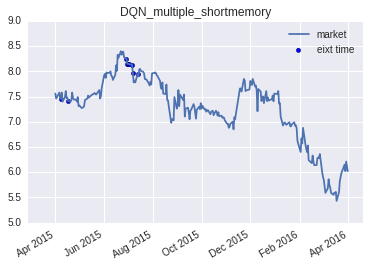

In [77]:
date_exit = []
stock_exit = []
fig, ax = plt.subplots()
for idx in exit_idx:
    date_exit.append(date_label[idx])
    stock_exit.append(trade_stock_data[idx])
ax.scatter(date_exit, stock_exit, label="eixt time")
ax.plot(date_label, trade_stock_data, label="market")
ax.legend()
plt.gcf().autofmt_xdate()
plt.title("DQN_multiple_shortmemory")
plt.savefig("DQN_mutliple_shortmemory")

In [78]:
import datetime

# test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
# trade_data = input_data[:, 0]
# train = input_data[:test_idx]
# test = input_data[test_idx:]
# date_test = date_label[test_idx:]
trade_stock_idx = 0
# n_stock = len(feature_data[0])

dqn = DQN_exit(model=model, target_model=model_target, n_stock=n_stock, n_history=n_history, 
               trade_stock_idx=trade_stock_idx, device="/cpu:0", target_device="/cpu:0", gam=1.0)
print ("start!")
exit_idx = dqn.training(feature_stock=feature_data, trade_stock=trade_stock_data, n_epochs=100,n_memory=10,
                                        init_cash=0, learning_rate=1e-2, date=date_label)
print ("finished!")

building model....
start!
training....
 optimal exit time:  2015-04-08 00:00:00
exit vs stay: 2015-04-08 00:00:00 0.984768 -0.00415894
update!
target weights [[-0.41083074]]
weights [[ 0.47234523]]
exit vs stay: 2015-04-09 00:00:00 0.981525 0.992476
exit vs stay: 2015-04-10 00:00:00 0.992511 0.994038
exit vs stay: 2015-04-13 00:00:00 0.997287 1.00026
exit vs stay: 2015-04-14 00:00:00 1.00598 1.00833
update!
target weights [[ 0.47234523]]
weights [[ 0.4730382]]
exit vs stay: 2015-04-15 00:00:00 0.978844 0.992224
exit vs stay: 2015-04-16 00:00:00 1.00463 1.01026
 optimal exit time:  2015-04-17 00:00:00
exit vs stay: 2015-04-17 00:00:00 1.03254 1.03098
exit vs stay: 2015-04-20 00:00:00 1.01421 1.02303
update!
target weights [[ 0.4730382]]
weights [[ 0.47245947]]
exit vs stay: 2015-04-21 00:00:00 1.00566 1.02161
exit vs stay: 2015-04-22 00:00:00 1.02045 1.03593
exit vs stay: 2015-04-23 00:00:00 1.01477 1.03512
exit vs stay: 2015-04-24 00:00:00 1.01642 1.04133
update!
target weights [[ 0.47

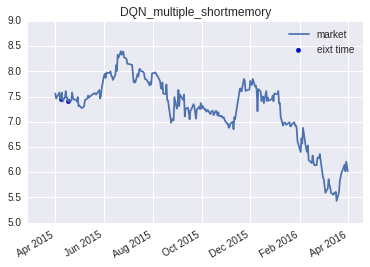

In [79]:
date_exit = []
stock_exit = []
fig, ax = plt.subplots()
for idx in exit_idx:
    date_exit.append(date_label[idx])
    stock_exit.append(trade_stock_data[idx])
ax.scatter(date_exit, stock_exit, label="eixt time")
ax.plot(date_label, trade_stock_data, label="market")
ax.legend()
plt.gcf().autofmt_xdate()
plt.title("DQN_multiple_shortmemory")
plt.savefig("DQN_mutliple_shortmemory")

In [35]:
# CNN model
from keras.layers.convolutional import Convolution1D
from keras.layers.pooling import MaxPooling1D 
from keras.layers.core import Flatten
n_history = 4
n_actions = 3
n_stock = len(input_data[0])

CNN = Sequential()
n_in = n_history * n_stock + 1
# layer_0
# input_shape = (number of dimetions, number of chaneels)
CNN.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', input_shape=(n_in, 1)))
CNN.add(BatchNormalization(mode=2))
CNN.add(Activation('relu'))
CNN.add(Convolution1D(nb_filter=64, filter_length=3, border_mode='same'))
CNN.add(BatchNormalization(mode=2))
CNN.add(Activation('relu'))
CNN.add(MaxPooling1D(pool_length=2, stride=None, border_mode='valid'))

# layer_1
CNN.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same'))
CNN.add(BatchNormalization(mode=2))
CNN.add(Activation('relu'))
CNN.add(MaxPooling1D(pool_length=2, stride=None, border_mode='valid'))

#layer_2
CNN.add(Flatten())
CNN.add(Dense(1000))
CNN.add(BatchNormalization(mode=2))
CNN.add(Activation("relu"))

# layer_3
CNN.add(Dense(30))
CNN.add(BatchNormalization(mode=2))
CNN.add(Activation("relu"))

# output layer
CNN.add(Dense(n_actions))

In [ ]:
print 

In [127]:
range(10, 0, -3)

[10, 7, 4, 1]

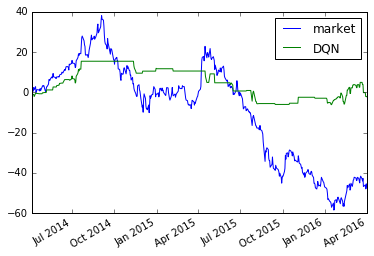

In [38]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, 0] - input_data[-n_data, 0]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [39]:
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
trade_data = input_data[:, 0]
train = input_data[:test_idx]
test = input_data[test_idx:]
date_test = date_label[test_idx:]
trade_stock_idx = 0


dqn = DQN(n_stock, model=CNN, n_actions=n_actions, trade_stock_idx=trade_stock_idx)
print ("start!")
value, state = dqn.training(stock_data=input_data, n_epochs=10, init_cash=0, decay_eps=0.95, min_eps=0.1)

building model....
start!
training....
t: 50, current value:6.439995, is_in:0, cash:6.439995, eps:0.100000
elapsed time 48.9514131546
t: 100, current value:6.449981, is_in:0, cash:6.449981, eps:0.100000
elapsed time 98.1003580093
t: 150, current value:12.319983, is_in:0, cash:12.319983, eps:0.100000
elapsed time 147.248795986
t: 200, current value:16.299966, is_in:1, cash:-96.970031, eps:0.100000
elapsed time 196.48043108
t: 250, current value:13.669968, is_in:0, cash:13.669968, eps:0.100000
elapsed time 245.748463154
t: 300, current value:11.929908, is_in:0, cash:11.929908, eps:0.100000
elapsed time 294.965508223
t: 350, current value:3.279906, is_in:1, cash:-84.270097, eps:0.100000
elapsed time 344.106672049
t: 400, current value:0.979919, is_in:1, cash:-77.180085, eps:0.100000
elapsed time 393.413367033
t: 450, current value:-4.190096, is_in:0, cash:-4.190096, eps:0.100000
elapsed time 442.654124022
t: 500, current value:-7.300114, is_in:0, cash:-7.300114, eps:0.100000
elapsed time 

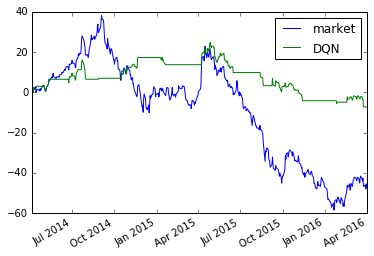

In [40]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, 0] - input_data[-n_data, 0]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

building model....
start!
training....
t: 50, current value:6.089996, is_in:0, cash:6.089996, eps:0.100000
elapsed time 465.700847864
t: 100, current value:7.559997, is_in:0, cash:7.559997, eps:0.100000
elapsed time 957.432828903
t: 150, current value:-7.480003, is_in:0, cash:-7.480003, eps:0.100000
elapsed time 1448.91203094
t: 200, current value:-11.990014, is_in:1, cash:-125.260011, eps:0.100000
elapsed time 1941.60124707
t: 250, current value:-14.460015, is_in:0, cash:-14.460015, eps:0.100000
elapsed time 2434.30690098
t: 300, current value:-18.180009, is_in:0, cash:-18.180009, eps:0.100000
elapsed time 2929.95852995
t: 350, current value:-20.220002, is_in:0, cash:-20.220002, eps:0.100000
elapsed time 3426.80753398
t: 400, current value:-20.710000, is_in:0, cash:-20.710000, eps:0.100000
elapsed time 3918.78294992
t: 450, current value:-21.950006, is_in:0, cash:-21.950006, eps:0.100000
elapsed time 4410.9810369
t: 500, current value:-22.130006, is_in:1, cash:-88.330003, eps:0.100000

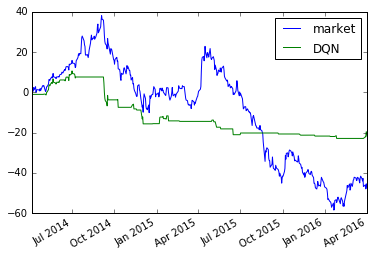

In [42]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, 0] - input_data[-n_data, 0]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [43]:
trade_stock_idx = 10
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
trade_data = input_data[:, trade_stock_idx]
train = input_data[:test_idx]
test = input_data[test_idx:]
date_test = date_label[test_idx:]

dqn = DQN(n_stock, model=CNN, n_actions=n_actions, trade_stock_idx=trade_stock_idx)
print ("start!")
value, state = dqn.training(stock_data=input_data, n_epochs=100, init_cash=0, decay_eps=0.95, min_eps=0.1)

building model....
start!
training....
t: 50, current value:0.550003, is_in:0, cash:0.550003, eps:0.100000
elapsed time 466.448385954
t: 100, current value:-0.789992, is_in:0, cash:-0.789992, eps:0.100000
elapsed time 958.435724974
t: 150, current value:-2.829989, is_in:0, cash:-2.829989, eps:0.100000
elapsed time 1449.86064315
t: 200, current value:-3.679988, is_in:0, cash:-3.679988, eps:0.100000
elapsed time 1941.1683681
t: 250, current value:-3.359985, is_in:0, cash:-3.359985, eps:0.100000
elapsed time 2433.72072601
t: 300, current value:-1.949990, is_in:0, cash:-1.949990, eps:0.100000
elapsed time 2925.48532701
t: 350, current value:-3.679998, is_in:1, cash:-36.819997, eps:0.100000
elapsed time 3417.30630708
t: 400, current value:-5.999995, is_in:0, cash:-5.999995, eps:0.100000
elapsed time 3908.84630013
t: 450, current value:-7.870001, is_in:0, cash:-7.870001, eps:0.100000
elapsed time 4400.165452
t: 500, current value:-5.919992, is_in:0, cash:-5.919992, eps:0.100000
elapsed time 

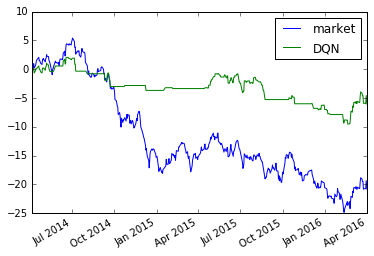

In [44]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, trade_stock_idx] - input_data[-n_data, trade_stock_idx]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [45]:
trade_stock_idx = 20
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
trade_data = input_data[:, trade_stock_idx]
train = input_data[:test_idx]
test = input_data[test_idx:]
date_test = date_label[test_idx:]

dqn = DQN(n_stock, model=CNN, n_actions=n_actions, trade_stock_idx=trade_stock_idx)
print ("start!")
value, state = dqn.training(stock_data=input_data, n_epochs=100, init_cash=0, decay_eps=0.95, min_eps=0.1)

building model....
start!
training....
t: 50, current value:-0.760002, is_in:0, cash:-0.760002, eps:0.100000
elapsed time 467.239156008
t: 100, current value:-0.810006, is_in:0, cash:-0.810006, eps:0.100000
elapsed time 959.142579794
t: 150, current value:0.499995, is_in:1, cash:-52.720006, eps:0.100000
elapsed time 1452.35737085
t: 200, current value:1.169989, is_in:1, cash:-50.080011, eps:0.100000
elapsed time 1943.67650795
t: 250, current value:4.629996, is_in:0, cash:4.629996, eps:0.100000
elapsed time 2435.13211679
t: 300, current value:6.329989, is_in:1, cash:-50.650011, eps:0.100000
elapsed time 2926.5471828
t: 350, current value:4.489993, is_in:1, cash:-51.970006, eps:0.100000
elapsed time 3417.4798789
t: 400, current value:3.979992, is_in:0, cash:3.979992, eps:0.100000
elapsed time 3909.86982989
t: 450, current value:-0.110014, is_in:1, cash:-51.840014, eps:0.100000
elapsed time 4401.46692801
t: 500, current value:0.109973, is_in:0, cash:0.109973, eps:0.100000
elapsed time 489

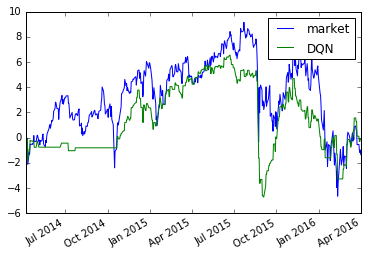

In [46]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, trade_stock_idx] - input_data[-n_data, trade_stock_idx]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [47]:
rade_stock_idx = 30
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
trade_data = input_data[:, trade_stock_idx]
train = input_data[:test_idx]
test = input_data[test_idx:]
date_test = date_label[test_idx:]

dqn = DQN(n_stock, model=CNN, n_actions=n_actions, trade_stock_idx=trade_stock_idx)
print ("start!")
value, state = dqn.training(stock_data=input_data, n_epochs=100, init_cash=0, decay_eps=0.95, min_eps=0.1)

building model....
start!
training....
t: 50, current value:0.189999, is_in:1, cash:-51.930000, eps:0.100000
elapsed time 468.925101042
t: 100, current value:1.229999, is_in:0, cash:1.229999, eps:0.100000
elapsed time 961.177663088
t: 150, current value:0.479999, is_in:0, cash:0.479999, eps:0.100000
elapsed time 1453.44061899
t: 200, current value:-0.439997, is_in:1, cash:-51.689997, eps:0.100000
elapsed time 1945.71940398
t: 250, current value:0.700007, is_in:1, cash:-53.689992, eps:0.100000
elapsed time 2438.02232695
t: 300, current value:1.730000, is_in:0, cash:1.730000, eps:0.100000
elapsed time 2930.25443387
t: 350, current value:2.440002, is_in:1, cash:-54.019997, eps:0.100000
elapsed time 3422.512393
t: 400, current value:-6.290004, is_in:0, cash:-6.290004, eps:0.100000
elapsed time 3914.78785205
t: 450, current value:-10.590014, is_in:1, cash:-62.320014, eps:0.100000
elapsed time 4406.96968889
t: 500, current value:-8.040025, is_in:0, cash:-8.040025, eps:0.100000
elapsed time 4

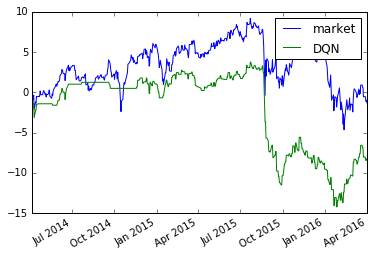

In [48]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, trade_stock_idx] - input_data[-n_data, trade_stock_idx]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [49]:
rade_stock_idx = 200
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))
trade_data = input_data[:, trade_stock_idx]
train = input_data[:test_idx]
test = input_data[test_idx:]
date_test = date_label[test_idx:]

dqn = DQN(n_stock, model=CNN, n_actions=n_actions, trade_stock_idx=trade_stock_idx)
print ("start!")
value, state = dqn.training(stock_data=input_data, n_epochs=100, init_cash=0, decay_eps=0.95, min_eps=0.1)

building model....
start!
training....
t: 50, current value:2.239994, is_in:1, cash:-49.880005, eps:0.100000
elapsed time 469.631244183
t: 100, current value:1.689991, is_in:1, cash:-49.650009, eps:0.100000
elapsed time 961.644835949
t: 150, current value:0.680001, is_in:0, cash:0.680001, eps:0.100000
elapsed time 1453.63253999
t: 200, current value:-0.040000, is_in:0, cash:-0.040000, eps:0.100000
elapsed time 1945.657938
t: 250, current value:-0.189999, is_in:1, cash:-54.579998, eps:0.100000
elapsed time 2437.70138311
t: 300, current value:0.469986, is_in:1, cash:-56.510014, eps:0.100000
elapsed time 2929.69802308
t: 350, current value:0.449986, is_in:0, cash:0.449986, eps:0.100000
elapsed time 3421.6886251
t: 400, current value:-1.380013, is_in:1, cash:-56.450013, eps:0.100000
elapsed time 3913.58780098
t: 450, current value:-1.890010, is_in:1, cash:-53.620010, eps:0.100000
elapsed time 4405.35813498
t: 500, current value:-4.250015, is_in:1, cash:-53.290016, eps:0.100000
elapsed time

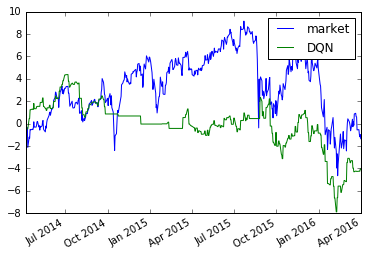

In [50]:
n_data = len(value)
date_tilde = date_label[-n_data:]
input_tilde = input_data[-n_data:, trade_stock_idx] - input_data[-n_data, trade_stock_idx]
plt.plot(date_tilde, input_tilde, label="market")
plt.plot(date_tilde, value, label="DQN")
plt.legend()
plt.gcf().autofmt_xdate()

In [51]:
pwd

u'/home/tomoaki/alpaca/notebooks/tomoaki/DQN'

In [75]:
a = np.random.randn(10, )

In [77]:
np.max(a, 0)

0.97203073653496908

In [78]:
a

array([ 0.25031729,  0.97203074,  0.40538324,  0.42544903, -0.61887916,
       -0.60104469, -1.06587294, -1.99898503,  0.07075299,  0.2656882 ])

In [9]:
from keras import backend as K
print (K.learning_phase())

Tensor("keras_learning_phase:0", dtype=uint8)


Using TensorFlow backend.


In [5]:
a = np.arange(10)
a[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])